In [1]:
# 07_team_similarity.ipynb
# 🤝 Team Similarity Finder

# Requirements: pandas, numpy, matplotlib, seaborn, scikit-learn (install via `pip install pandas numpy matplotlib seaborn scikit-learn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("flare")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())


Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🔎 What You'll Build

> **Beginner tip:** Similarity searches work best when you understand what each feature represents. Keep the feature list handy so you can connect the math to on-court style.

Use this notebook to locate stylistic twins across the college basketball landscape. You'll:
- confirm which seasons exist in the starter pack and pick one to explore
- engineer tempo-free feature vectors for every team
- normalize metrics to remove scale bias
- compute cosine similarity scores between teams
- surface nearest neighbors for any target team and visualize the landscape


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))


Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Configure analysis parameters
Start with the default metrics and number of neighbors. Once you see the output tables, adjust one setting at a time to learn how it changes the comps.

Pick the season, conference scope, and target team before re-running the notebook.


In [3]:
# 🔁 Parameters
TARGET_SEASON = 2020  # choose any season from the list above
TARGET_CONFERENCE = None  # e.g. 'SEC' to focus on one league, or None for all
MIN_GAMES = 10  # drop teams with limited sample sizes
TARGET_TEAM = 'Dayton'  # update to the team you want to analyze
SIMILARITY_TOP_K = 8  # count of similar teams to display

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All conferences'}")
print(f"Minimum games required: {MIN_GAMES}")
print(f"Target team: {TARGET_TEAM}")
print(f"Nearest neighbors to return: {SIMILARITY_TOP_K}")


Analyzing season: 2020
Conference filter: All conferences
Minimum games required: 10
Target team: Dayton
Nearest neighbors to return: 8


## 📥 Load season metrics
We load the season-long stats once so the rest of the notebook can reuse them. Confirm the preview includes the columns you expect before moving on.

Season-level team tables contain the tempo-free stats needed for building similarity features.


In [4]:
# 🗂️ Read team season stats
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_season = pd.read_csv(team_season_path)

# Remove rows without conference detail
team_season = team_season.dropna(subset=['conference']).copy()

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()

print(f"Teams with conference assignments: {len(team_season):,}")
display(team_season[['team', 'conference', 'games', 'wins', 'teamStats_rating']].head())


Teams with conference assignments: 359


,team,conference,games,wins,teamStats_rating
0,Abilene Christian,Southland,31,20,133.00
1,Air Force,Mountain West,32,12,107.30
2,Akron,MAC,31,24,120.00
3,Alabama A&M,SWAC,30,8,109.60
4,Alabama,SEC,31,16,111.30


## 🏗️ Assemble feature set
Each feature captures a style trait (tempo, efficiency, shooting). If a stat name is unfamiliar, look it up in the data dictionary to keep the context clear.

Select tempo-free metrics that capture style. Remove teams under the game threshold to keep comparisons stable.


In [5]:
# 🔢 Feature engineering
feature_columns = [
    'pace',
    'teamStats_rating',
    'opponentStats_rating',
    'teamStats_fourFactors_effectiveFieldGoalPct',
    'opponentStats_fourFactors_effectiveFieldGoalPct',
    'teamStats_fourFactors_turnoverRatio',
    'opponentStats_fourFactors_turnoverRatio',
    'teamStats_fourFactors_offensiveReboundPct',
    'opponentStats_fourFactors_offensiveReboundPct',
    'teamStats_fourFactors_freeThrowRate',
    'opponentStats_fourFactors_freeThrowRate',
    'teamStats_trueShooting'
]

metric_frame = (
    team_season
    .loc[:, ['teamId', 'team', 'conference', 'games', 'wins', 'losses'] + feature_columns]
)

metric_frame = metric_frame.query('games >= @MIN_GAMES').reset_index(drop=True)

if metric_frame.empty:
    raise ValueError('No teams left after applying MIN_GAMES filter. Lower the threshold or expand filters.')

metric_frame = metric_frame.assign(
    net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating']
)

display(metric_frame.head())


,teamId,team,conference,games,wins,losses,pace,teamStats_rating,opponentStats_rating,teamStats_fourFactors_effectiveFieldGoalPct,opponentStats_fourFactors_effectiveFieldGoalPct,teamStats_fourFactors_turnoverRatio,opponentStats_fourFactors_turnoverRatio,teamStats_fourFactors_offensiveReboundPct,opponentStats_fourFactors_offensiveReboundPct,teamStats_fourFactors_freeThrowRate,opponentStats_fourFactors_freeThrowRate,teamStats_trueShooting,net_rating
0,1,Abilene Christian,Southland,31,20,11,54.30,133.00,114.90,50.70,48.20,0.25,0.35,32.30,26.20,38.30,47.10,55.50,18.10
1,2,Air Force,Mountain West,32,12,20,67.90,107.30,110.00,53.40,55.50,0.18,0.17,22.80,22.60,35.70,29.30,57.40,-2.70
2,3,Akron,MAC,31,24,7,63.10,120.00,105.40,52.10,45.10,0.20,0.21,25.80,31.50,35.20,28.60,56.80,14.60
3,4,Alabama A&M,SWAC,30,8,22,55.40,109.60,127.40,42.40,51.20,0.23,0.23,27.90,24.30,32.70,35.10,46.70,-17.80
4,5,Alabama,SEC,31,16,15,70.80,111.30,107.10,52.20,47.90,0.20,0.19,29.80,31.00,36.90,35.90,55.90,4.20


## ⚖️ Standardize feature space
Standardizing puts every metric on the same scale. Without it, metrics measured on larger scales would dominate the similarity score.

Scale each feature so no single metric dominates distance calculations.


In [6]:
# 📐 Normalize features
scaler = StandardScaler()
features = metric_frame[feature_columns]
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(
    scaled_features,
    columns=[f'{col}_scaled' for col in feature_columns],
    index=metric_frame['team']
)

display(scaled_df.head())


,pace_scaled,teamStats_rating_scaled,opponentStats_rating_scaled,teamStats_fourFactors_effectiveFieldGoalPct_scaled,opponentStats_fourFactors_effectiveFieldGoalPct_scaled,teamStats_fourFactors_turnoverRatio_scaled,opponentStats_fourFactors_turnoverRatio_scaled,teamStats_fourFactors_offensiveReboundPct_scaled,opponentStats_fourFactors_offensiveReboundPct_scaled,teamStats_fourFactors_freeThrowRate_scaled,opponentStats_fourFactors_freeThrowRate_scaled,teamStats_trueShooting_scaled
team,,,,,,,,,,,,
Abilene Christian,-1.47,1.48,0.34,0.26,-0.38,1.14,3.78,1.26,-0.68,1.22,2.53,0.64
Air Force,0.82,-0.28,0.04,1.22,2.39,-0.73,-1.07,-1.47,-2.09,0.68,-0.53,1.35
Akron,0.01,0.59,-0.25,0.76,-1.55,-0.19,0.00,-0.61,1.40,0.57,-0.65,1.13
Alabama A&M,-1.28,-0.12,1.10,-2.71,0.76,0.61,0.54,-0.00,-1.43,0.04,0.47,-2.66
Alabama,1.30,-0.01,-0.14,0.79,-0.49,-0.19,-0.54,0.54,1.20,0.93,0.60,0.79


## 🤖 Compute cosine similarity
Cosine similarity compares the direction of each team's stat vector. Values near 1 mean the teams profile similarly across all metrics.

Cosine similarity highlights shared style regardless of magnitude. Values closer to 1 indicate tighter stylistic overlap.


In [7]:
# 🔍 Similarity matrix
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=metric_frame['team'],
    columns=metric_frame['team']
)

print('Similarity matrix preview:')
display(similarity_df.iloc[:5, :5])


Similarity matrix preview:


team,Abilene Christian,Air Force,Akron,Alabama A&M,Alabama
team,,,,,
Abilene Christian,1.00,-0.30,-0.04,0.17,-0.06
Air Force,-0.30,1.00,-0.21,-0.22,-0.03
Akron,-0.04,-0.21,1.00,-0.71,0.54
Alabama A&M,0.17,-0.22,-0.71,1.00,-0.71
Alabama,-0.06,-0.03,0.54,-0.71,1.00


## 🧭 Find nearest neighbors
Use this table to spot stylistic comps. Ask yourself: do these results match what I know from watching? If not, revisit the feature list.

Create a helper to pull the most similar teams for the selected program and review the comparison table.


In [8]:
# 🧑‍🤝‍🧑 Helper to fetch similar teams
def get_similar_teams(team_name: str, top_k: int = 10) -> pd.DataFrame:
    if team_name not in similarity_df.index:
        raise ValueError(f"Team '{team_name}' not found. Check TARGET_TEAM or adjust filters.")
    scores = similarity_df.loc[team_name].drop(team_name)
    top_matches = scores.sort_values(ascending=False).head(top_k).index
    result = metric_frame.set_index('team').loc[top_matches, ['conference', 'games', 'wins', 'losses', 'net_rating']].copy()
    result.insert(0, 'similarity', scores.loc[top_matches].round(4))
    return result.reset_index().rename(columns={'index': 'team'})

similar_table = get_similar_teams(TARGET_TEAM, top_k=SIMILARITY_TOP_K)
display(similar_table)


,team,similarity,conference,games,wins,losses,net_rating
0,North Texas,0.85,CUSA,31,20,11,12.20
1,South Dakota State,0.81,Summit,32,22,10,12.30
2,San Diego State,0.81,Mountain West,32,30,2,23.20
3,Gonzaga,0.80,WCC,33,31,2,27.70
4,Furman,0.79,SoCon,32,25,7,15.20
5,BYU,0.78,WCC,32,24,8,16.80
6,Delaware,0.77,CAA,33,22,11,6.10
7,Ohio State,0.77,Big Ten,31,21,10,13.60


## 📈 Visualize neighbors
The scatter plot shows how the chosen team compares on two key metrics. Check whether the neighbors cluster around your target team.

Plot the target team and its stylistic neighbors in pace vs. net rating space for quick intuition.


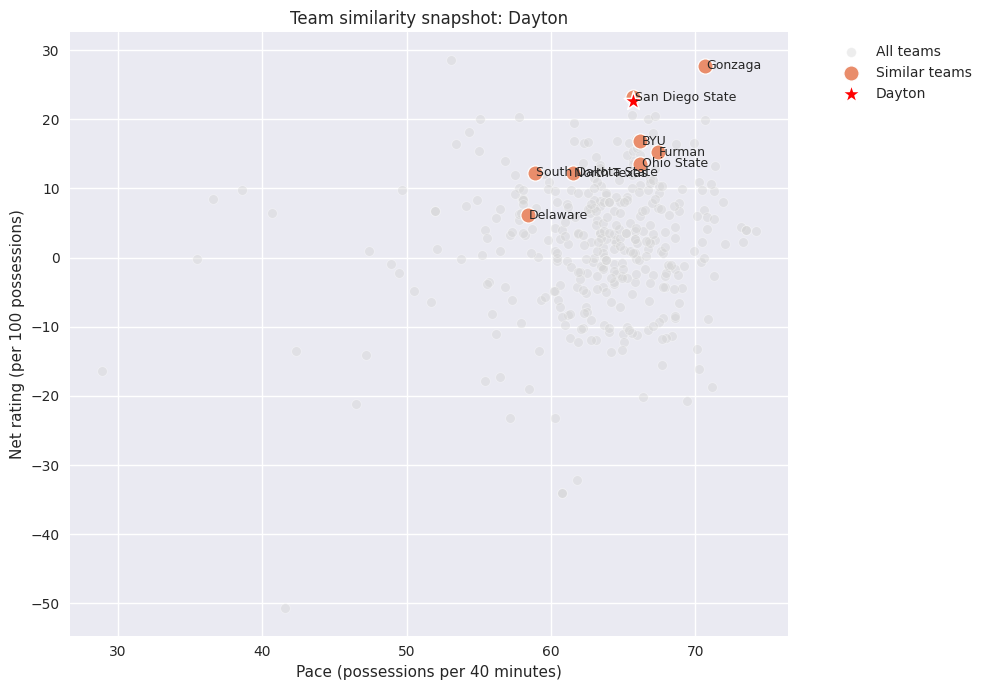

In [9]:
# 🗺️ Pace vs net rating view
plot_data = metric_frame.set_index('team')
target_point = plot_data.loc[[TARGET_TEAM]]
neighbor_points = plot_data.loc[similar_table['team']]

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=plot_data, x='pace', y='net_rating', color='lightgray', alpha=0.4, ax=ax, label='All teams')
sns.scatterplot(data=neighbor_points, x='pace', y='net_rating', s=120, ax=ax, label='Similar teams')
sns.scatterplot(data=target_point, x='pace', y='net_rating', s=200, ax=ax, color='red', marker='*', label=TARGET_TEAM)

for team_name, row in neighbor_points.iterrows():
    ax.text(row['pace'] + 0.1, row['net_rating'], team_name, fontsize=9, ha='left', va='center')

ax.set_title(f'Team similarity snapshot: {TARGET_TEAM}')
ax.set_xlabel('Pace (possessions per 40 minutes)')
ax.set_ylabel('Net rating (per 100 possessions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 🔥 Similarity heatmap
Heatmaps highlight patterns across many teams at once. Focus on the darker cells—they signal tighter stylistic matches.

Inspect the pairwise similarity matrix for the target and closest peers to see where the clustering is tightest.


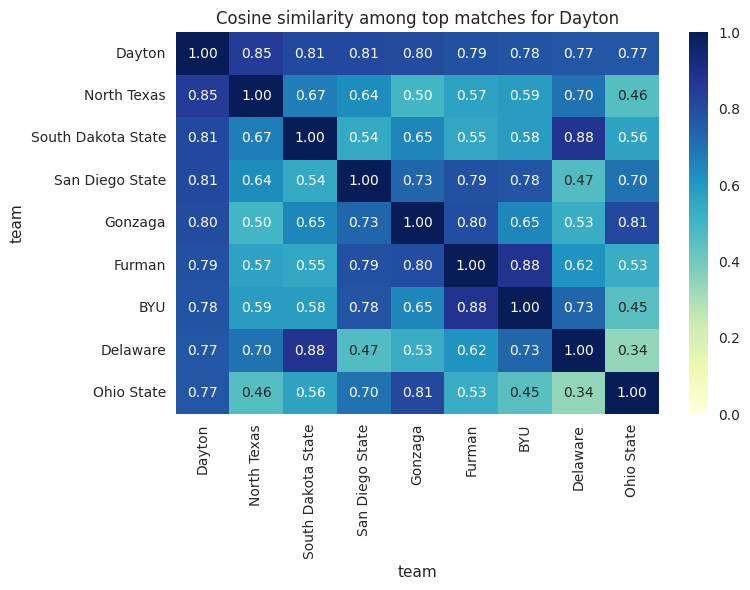

In [10]:
# 🔥 Heatmap of top similarities
focus_teams = [TARGET_TEAM] + similar_table['team'].tolist()
focus_sim = similarity_df.loc[focus_teams, focus_teams]

plt.figure(figsize=(8, 6))
sns.heatmap(focus_sim, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title(f'Cosine similarity among top matches for {TARGET_TEAM}')
plt.tight_layout()
plt.show()


## ✅ Next steps
Save the neighbors for teams you scout regularly. They provide useful film study ideas and help with opponent preparation.

- Export `similarity_df` or `similar_table` as CSV to integrate with scouting reports.
- Swap the feature set to emphasize specific styles (e.g., add shooting splits or rebounding).
- Pair with `05_team_vs_conference_averages.ipynb` to contextualize similarities within each league.
